In [1]:
import findspark
findspark.init()
findspark.find()

'H:\\SPARK'

In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession with necessary configurations
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('Spark') \
    .config("spark.driver.memory", "15g") \
    .config("spark.hadoop.home.dir", "H:/HADOOP/") \
    .config("spark.hadoop.conf.dir", "H:/HADOOP/etc/hadoop/") \
    .getOrCreate()
    
import sys
sys.path.append("G:\Dissertation_Project")

# Get SparkContext from the SparkSession
sc = spark.sparkContext


In [3]:
spark

### BASE DATASET

In [4]:
base_df = spark.read.csv("../../Data/Custom_Datasets/conversation_datasets_GPT.csv", header=True, inferSchema=True)
base_df.show(10, truncate=False)

+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Conversation_ID|Attacker_Helper                                                                                                                                                 |Victim                                                                                                                                                                                         |Conversation_Type|
+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------

### PREPROCESSED DATASET

In [5]:
preprocessed_df = spark.read.csv("../../Data/Preprocessed_Datasets/GPT_dataset_preprocessed.csv", header=True, inferSchema=True)
preprocessed_df.show(10, truncate=False)

+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Convert Conversation Columns into actual Arrays

In [6]:
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import ast

# UDF to convert string representation of list to actual list
def str_to_array_of_arrays(s):
    # Convert the string to a list and then wrap it inside another list
    return [ast.literal_eval(s)][0]

str_to_array_of_arrays_udf = udf(str_to_array_of_arrays, ArrayType(ArrayType(StringType())))

df = preprocessed_df.withColumn("Attacker_Helper", str_to_array_of_arrays_udf(preprocessed_df["Attacker_Helper"])).withColumn("Victim", str_to_array_of_arrays_udf(preprocessed_df["Victim"]))

df.printSchema()

root
 |-- Conversation_ID: string (nullable = true)
 |-- Attacker_Helper: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Victim: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- Conversation_Type: integer (nullable = true)



### Loading the pipeline and transforming the data

In [7]:
from pyspark.ml import PipelineModel
from src.CustonTransformers import FlattenTransformer

pipeline_model_path = "./Pipelines/TF-IDF_Pipeline"

pipeline = PipelineModel.load(path=pipeline_model_path)

df_assembled = pipeline.transform(df)

### Splitting the Data

In [8]:
(train_data, test_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)
train_data.show(truncate=False)

+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# NEURAL NETWORK

## Creating a LSTM neural network using keras. 

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

### Preparing the data to be used as input in the Neural Network

In [18]:
import numpy 

labels = train_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_train = numpy.array(labels)

print("Shape of -labels_numpy_train- array --> {}".format(labels_numpy_train.shape))

features = train_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_train = numpy.array(features)
features_numpy_train = numpy.expand_dims(features_numpy_train, axis=1)

print("Shape of -features_numpy_train- array --> {}".format(features_numpy_train.shape))

###############################################################################################################

labels = test_data.select('Conversation_Type').rdd.map(lambda row: row.Conversation_Type).collect()
labels_numpy_test = numpy.array(labels)

print("Shape of -labels_numpy_train- array --> {}".format(labels_numpy_test.shape))

features = test_data.select('combined_features').rdd.map(lambda row: row.combined_features).collect()
features_numpy_test = numpy.array(features)
features_numpy_test = numpy.expand_dims(features_numpy_test, axis=1)

print("Shape of -features_numpy_train- array --> {}".format(features_numpy_test.shape))



Shape of -labels_numpy_train- array --> (173,)
Shape of -features_numpy_train- array --> (173, 1, 36)
Shape of -labels_numpy_train- array --> (32,)
Shape of -features_numpy_train- array --> (32, 1, 36)


In [25]:
model = Sequential([
    LSTM(32, input_shape=(1, 36), return_sequences=True),
    Dropout(0.5),
    LSTM(16, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
# early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=10,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(features_numpy_train, labels_numpy_train, epochs=160, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/160


5/5 [==============================] - 4s 165ms/step - loss: 0.6944 - accuracy: 0.4710 - val_loss: 0.6934 - val_accuracy: 0.5143
Epoch 2/160
5/5 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.4783 - val_loss: 0.6921 - val_accuracy: 0.5429
Epoch 3/160
5/5 [==============================] - 0s 10ms/step - loss: 0.6922 - accuracy: 0.5652 - val_loss: 0.6912 - val_accuracy: 0.5714
Epoch 4/160
5/5 [==============================] - 0s 10ms/step - loss: 0.6912 - accuracy: 0.6014 - val_loss: 0.6900 - val_accuracy: 0.7714
Epoch 5/160
5/5 [==============================] - 0s 10ms/step - loss: 0.6890 - accuracy: 0.7101 - val_loss: 0.6887 - val_accuracy: 0.8000
Epoch 6/160
5/5 [==============================] - 0s 9ms/step - loss: 0.6886 - accuracy: 0.6884 - val_loss: 0.6869 - val_accuracy: 0.7714
Epoch 7/160
5/5 [==============================] - 0s 9ms/step - loss: 0.6884 - accuracy: 0.6739 - val_loss: 0.6850 - val_accuracy: 0.6857
Epoch 8/160
5/5 [================

### Testing the LSTM network

In [28]:
test_loss, test_accuracy = model.evaluate(features_numpy_test, labels_numpy_test)
print(f"Test accuracy --> {test_accuracy}")

1/1 [==============================] - 0s 19ms/step - loss: 0.3835 - accuracy: 0.8750
Test accuracy --> 0.875


### Saving the model

In [29]:
model.save("../Models/Trained_Models/LSTM_NeuralNetwork_TFIDF/LSTM_NeuralNetwork_TFIDF.keras")

### Plotting the training results

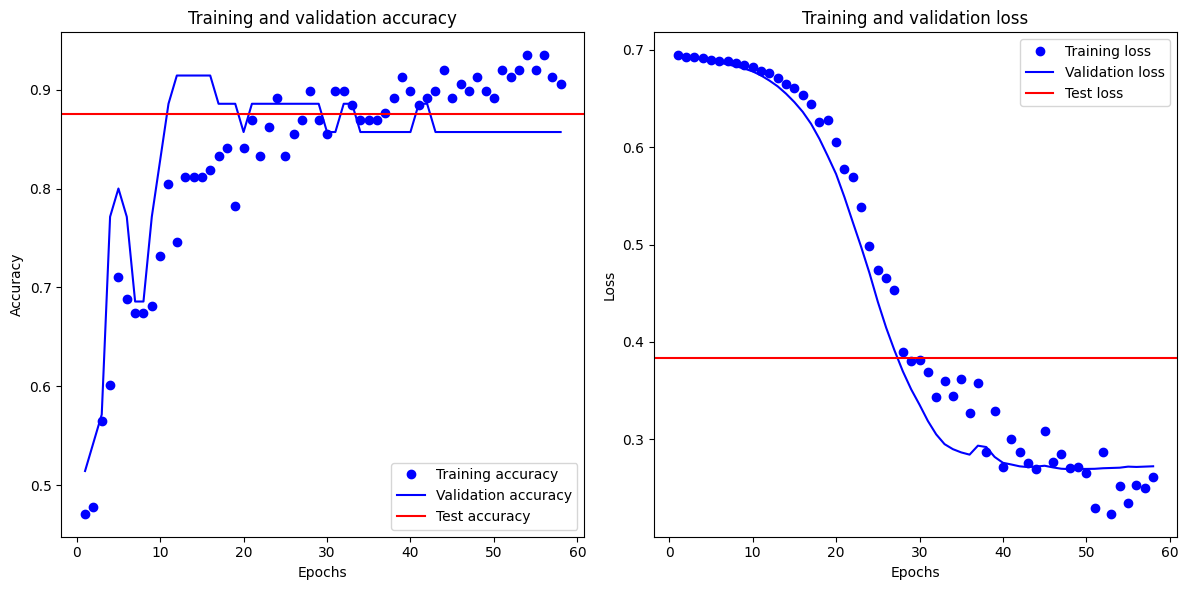

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

history_dict = history.history

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(accuracy) + 1)


plt.figure(figsize=(12, 6))

# Plot training and validation accuracy per epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='-', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot training and validation loss per epoch
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()